In [45]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"

## Define Network

In [46]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28*28*1, 64)
        self.fc_2 = nn.Linear(64, 128)
        self.fc_3 = nn.Linear(128, 10)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = F.relu(self.fc_2(out))
        out = self.fc_3(out)

        return out


class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64 * 4 * 4, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [50]:
model_untrained = MLP()
model_pretrained = MLP()

model_pretrained.load_state_dict(
    torch.load("data/model_checkpoint.pt")
)

model_untrained, model_pretrained = model_untrained.to(device), model_pretrained.to(device)

In [58]:
# mlp = MLP()
# conv = ConvNet()
# mlp, conv = mlp.to(device), conv.to(device)

dataset = torch.load("../model_robustness/data/MNIST/dataset.pt")

# dataset = torch.load("data/FashionMNIST/dataset.pt")

trainset = dataset["trainset"]
testset = dataset["testset"]

trainloader = DataLoader(
    dataset=trainset,
    batch_size=16,
    shuffle=True,
)
testloader = DataLoader(
    dataset=testset,
    batch_size=16,
    shuffle=False
)

In [59]:
def epoch(mode, device, net, dataloader, optimizer, criterion):
    loss_avg, acc_avg, num_exp = 0,0,0
    if mode == "train":
        net.train()

    else:
        net.eval()

    for i, data in enumerate(dataloader):
        imgs, labels = data
        imgs = imgs.to(device)
        labels = labels.to(device)

        n_b = labels.shape[0]

        outputs = net(imgs)
        loss = criterion(outputs, labels)

        acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), labels.cpu().data.numpy()))

        loss_avg += loss.item()
        acc_avg += acc
        num_exp += n_b

        if mode == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg

## Define perturbed testloaders

In [60]:
aux_loader = DataLoader(
    dataset=testset,
    batch_size=5,
    shuffle=False
)

for cln_data, true_label in aux_loader:
    break

cln_data, true_label = cln_data.to(device), true_label.to(device)

In [61]:
from advertorch.attacks import GradientSignAttack

# white_adversary = GradientSignAttack(
#     mlp,
#     loss_fn=nn.CrossEntropyLoss(reduction="sum"),
#     eps=0.15,
#     targeted=False
# )
#
# black_adversary = GradientSignAttack(
#     conv,
#     loss_fn=nn.CrossEntropyLoss(reduction="sum"),
#     eps=0.15,
#     targeted=False
# )

untrained_adversary = GradientSignAttack(
    model_untrained,
    loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=0.15,
    targeted=False
)

pretrained_adversary = GradientSignAttack(
    model_pretrained,
    loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=0.15,
    targeted=False
)

In [17]:
# white_untargeted = white_adversary.perturb(cln_data, true_label)
# black_untargeted = black_adversary.perturb(cln_data, true_label)

In [18]:
# white_data = torch.utils.data.TensorDataset(white_untargeted, true_label)
# white_loader = DataLoader(
#     dataset=white_data,
#     batch_size=16,
#     shuffle=False
# )
#
# black_data = torch.utils.data.TensorDataset(black_untargeted, true_label)
# black_loader = DataLoader(
#     dataset=black_data,
#     batch_size=16,
#     shuffle=False
# )

In [62]:
untrained_untargeted = untrained_adversary.perturb(cln_data, true_label)
pretrained_untargeted = pretrained_adversary.perturb(cln_data, true_label)

# white_data = torch.utils.data.TensorDataset(untrained_untargeted, true_label)
# white_loader = DataLoader(
#     dataset=white_data,
#     batch_size=16,
#     shuffle=False
# )
#
# black_data = torch.utils.data.TensorDataset(pretrained_untargeted, true_label)
# black_loader = DataLoader(
#     dataset=black_data,
#     batch_size=16,
#     shuffle=False
# )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


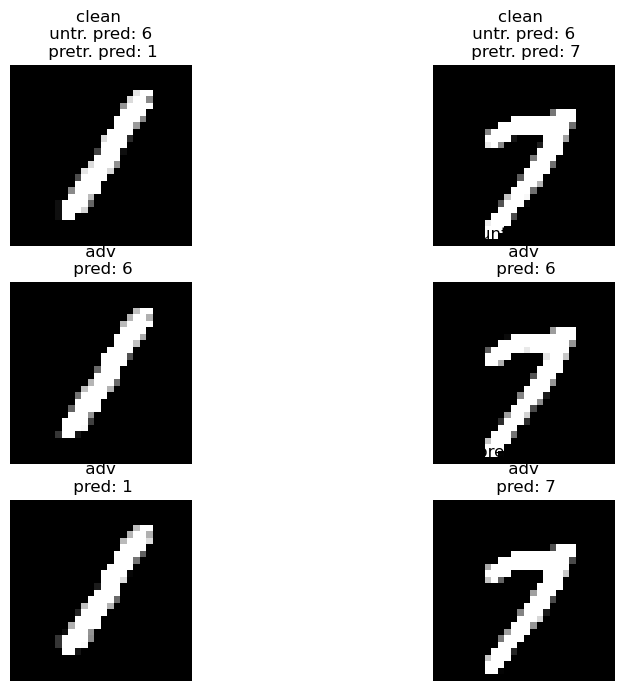

In [67]:
# Visualization of attacks
from advertorch.utils import predict_from_logits
from advertorch_examples.utils import _imshow

# net.eval()
# pred_cln = predict_from_logits(model(cln_data))
# pred_untargeted = predict_from_logits(model(adv_untargeted))
# pred_targeted = predict_from_logits(model(adv_targeted))

model_pretrained.eval()
model_untrained.eval()

pred_cln_un = predict_from_logits(model_untrained(cln_data))
pred_cln_pre = predict_from_logits(model_pretrained(cln_data))
pred_un = predict_from_logits(model_untrained(untrained_untargeted))
pred_pre = predict_from_logits(model_pretrained(pretrained_untargeted))

plt.figure(figsize=(10,8))
for ii in range(2):
    plt.subplot(3, 2, ii+1)
    _imshow(cln_data[ii])
    plt.title("clean \n untr. pred: {} \n pretr. pred: {}".format(pred_cln_un[ii], pred_cln_pre[ii]))
    plt.subplot(3,2, ii+1+2)
    _imshow(untrained_untargeted[ii])
    plt.title("untrained \n adv \n pred: {}".format(pred_un[ii]))
    plt.subplot(3,2, ii+1+2*2)
    _imshow(pretrained_untargeted[ii])
    plt.title("pretrained \n adv \n pred: {}".format(pred_pre[ii]))

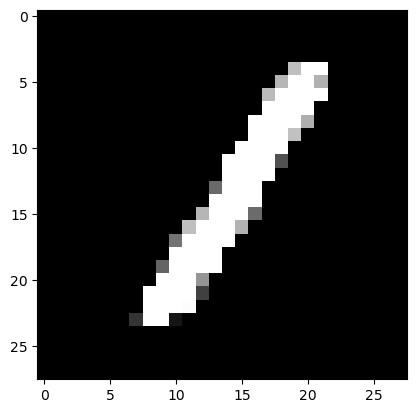

In [56]:
plt.imshow(np.moveaxis(untrained_untargeted[0].detach().cpu().numpy(), 0, 2), cmap='gray')

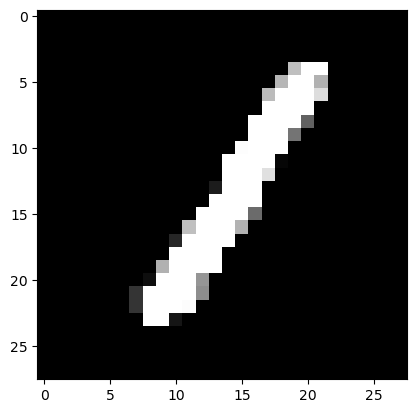

In [57]:
plt.imshow(np.moveaxis(pretrained_untargeted[0].detach().cpu().numpy(), 0, 2), cmap='gray')

## Setting up training

In [21]:
optimizer_white = optim.Adam(mlp.parameters(), lr=0.01)
optimizer_black = optim.Adam(conv.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [23]:
for e in range(10):
    train_loss, train_acc = epoch("train", device, mlp, trainloader, optimizer_white, criterion)
    print(f"[{e +1}] TRAINING \n loss: {train_loss:.3f}, accuracy: {train_acc:.3f}")

    test_loss, test_acc = epoch("test", device, mlp, testloader, optimizer_white, criterion)
    print(f"[{e + 1}] TESTING \n loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

    test_loss, test_acc = epoch("test", device, mlp, white_loader, optimizer_white, criterion)
    print(f"[{e + 1}] PERTURBATION WHITE-BOX \n loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

    test_loss, test_acc = epoch("test", device, mlp, black_loader, optimizer_black, criterion)
    print(f"[{e + 1}] PERTURBATION BLACK-BOX \n loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

[1] TRAINING 
 loss: 0.027, accuracy: 0.852
[1] TESTING 
 loss: 0.030, accuracy: 0.842
[1] PERTURBATION WHITE-BOX 
 loss: 0.088, accuracy: 0.548
[1] PERTURBATION BLACK-BOX 
 loss: 0.087, accuracy: 0.562
[2] TRAINING 
 loss: 0.026, accuracy: 0.853
[2] TESTING 
 loss: 0.031, accuracy: 0.838
[2] PERTURBATION WHITE-BOX 
 loss: 0.080, accuracy: 0.599
[2] PERTURBATION BLACK-BOX 
 loss: 0.086, accuracy: 0.615
[3] TRAINING 
 loss: 0.026, accuracy: 0.855
[3] TESTING 
 loss: 0.031, accuracy: 0.841
[3] PERTURBATION WHITE-BOX 
 loss: 0.093, accuracy: 0.542
[3] PERTURBATION BLACK-BOX 
 loss: 0.102, accuracy: 0.556
[4] TRAINING 
 loss: 0.025, accuracy: 0.859
[4] TESTING 
 loss: 0.033, accuracy: 0.831
[4] PERTURBATION WHITE-BOX 
 loss: 0.110, accuracy: 0.519
[4] PERTURBATION BLACK-BOX 
 loss: 0.119, accuracy: 0.537
[5] TRAINING 
 loss: 0.025, accuracy: 0.857
[5] TESTING 
 loss: 0.029, accuracy: 0.849
[5] PERTURBATION WHITE-BOX 
 loss: 0.140, accuracy: 0.540
[5] PERTURBATION BLACK-BOX 
 loss: 0.152, a

## Trying to load in checkpoint from model zoo

In [26]:
import os
directory = "../model_robustness/data/mnist_seed/tune_zoo_mnist_uniform"

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        print(f)
    break

../model_robustness/data/mnist_seed/tune_zoo_mnist_uniform\config.json


In [27]:
class ConvNetSmall(nn.Module):

    def __init__(
            self,
            channels_in,
            nlin="leakyrelu",
            dropout=0.2,
            init_type="uniform"
    ):
        super().__init__()

        self.module_list = nn.ModuleList()

        self.module_list.append(nn.Conv2d(1, 8, 5))
        self.module_list.append(nn.MaxPool2d(2, 2))
        self.module_list.append(nn.LeakyReLU())
        self.module_list.append(nn.Dropout(dropout))

        self.module_list.append(nn.Conv2d(8, 6, 5))
        self.module_list.append(nn.MaxPool2d(2, 2))
        self.module_list.append(nn.LeakyReLU())
        self.module_list.append(nn.Dropout(dropout))

        self.module_list.append(nn.Conv2d(6, 4, 2))
        self.module_list.append(nn.LeakyReLU())

        self.module_list.append(self.get_nonli)


        self.conv2 = nn.Conv2d(8, 6, 5)
        self.conv3 = nn.Conv2d(6, 4, 2)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(3*3*4, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = nn.MaxPool2d(nn.ReLU(self.conv1(x)), (2, 2))
        x = nn.MaxPool2d(nn.ReLU(self.conv2(x)), (2, 2))
        x = nn.MaxPool2d(nn.ReLU(self.conv3(x)), (2, 2))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = nn.ReLU(self.fc1(x))
        x = self.fc2(x)
        return x

In [33]:
directory = \
    "../model_robustness/data/mnist_seed/tune_zoo_mnist_uniform/NN_tune_trainable_c0371_00000_0_seed=1_2021-07-01_16-59-53/checkpoint_000050"

model = ConvNetSmall()

model.load_state_dict(
    torch.load(os.path.join(directory, "optim_final_state"))
)

RuntimeError: Error(s) in loading state_dict for ConvNetSmall:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "state", "param_groups". 

In [41]:
torch.load(os.path.join(directory, "optim_final_state"))["param_groups"]

[{'lr': 0.0003,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0.0,
  'amsgrad': False,
  'params': [140325754022000,
   140325754022072,
   140325754022288,
   140325754022360,
   140325754022648,
   140325754022720,
   140325754023008,
   140325754023080,
   140325754023296,
   140325754023368]}]

In [44]:
torch.load(os.path.join(directory, "checkpoints")).keys()

odict_keys(['module_list.0.weight', 'module_list.0.bias', 'module_list.3.weight', 'module_list.3.bias', 'module_list.6.weight', 'module_list.6.bias', 'module_list.9.weight', 'module_list.9.bias', 'module_list.11.weight', 'module_list.11.bias'])

In [ ]:
C:\Users\juliu\repos\model_robustness\src\model_robustness\data\mnist_seed\tune_zoo_mnist_uniform\NN_tune_trainable_c0371_00000_0_seed=1_2021-07-01_16-59-53\checkpoint_000050\optim_final_state